## Test New 3DEP SlideRule Capabilities

In [28]:
# From boulder_watershed_demo.ipynb
import logging
import geopandas as gpd
import matplotlib.pyplot as plt
from sliderule import icesat2

# From 3dep_gedi_sample.ipynb
import time
from sliderule import earthdata, raster
import sliderule

In [29]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", False)

In [39]:
!cd ../../data/site_outlines/

In [40]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_methow/notebooks


In [41]:
poly_fn = 'methow_outline_4326.geojson'
region = sliderule.toregion(poly_fn)

In [44]:
poly = region["poly"]
lats = [p["lat"] for p in poly]
lons = [p["lon"] for p in poly]
bbox = [
    {'lat': min(lats), 'lon': min(lons)}, # ll
    {'lat': min(lats), 'lon': max(lons)}, # lr
    {'lat': max(lats), 'lon': max(lons)}, # ur
    {'lat': max(lats), 'lon': min(lons)}, # ul
    {'lat': min(lats), 'lon': min(lons)}, # ll
]

In [42]:
len(region['poly'])

106

In [35]:
region["poly"]

[{'lon': -120.03086975948115, 'lat': 48.23998489506269},
 {'lon': -120.03085972550102, 'lat': 48.23998489506269},
 {'lon': -120.03059884201778, 'lat': 48.239994929042815},
 {'lon': -120.03032792455443, 'lat': 48.240014997003065},
 {'lon': -120.03016738087244, 'lat': 48.240035064963315},
 {'lon': -120.03011721097181, 'lat': 48.24004509894344},
 {'lon': -120.01960159980142, 'lat': 48.242503424073924},
 {'lon': -120.01956146388092, 'lat': 48.24251345805405},
 {'lon': -120.0194310221393, 'lat': 48.24255359397454},
 {'lon': -120.01930058039768, 'lat': 48.24259372989504},
 {'lon': -120.00092836278986, 'lat': 48.24987839946537},
 {'lon': -120.00082802298861, 'lat': 48.24991853538587},
 {'lon': -120.00067751328676, 'lat': 48.249978739266616},
 {'lon': -120.0002861880619, 'lat': 48.250149316928734},
 {'lon': -120.0000855084594, 'lat': 48.25024965672998},
 {'lon': -119.99996510069792, 'lat': 48.25030986061072},
 {'lon': -119.99986476089667, 'lat': 48.25037006449147},
 {'lon': -119.99982462497618

In [11]:
region2 = gpd.read_file(poly_fn)

<Axes: >

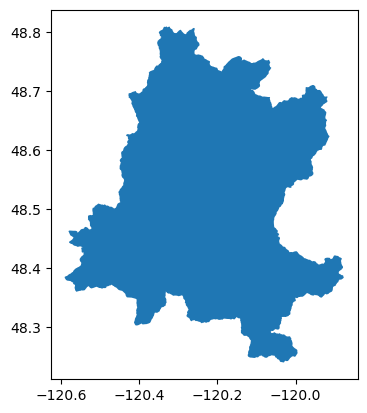

In [20]:
region2.plot()

In [10]:
earthdata.tnm?

Signature:
earthdata.tnm(
    short_name,
    polygon,
    time_start=None,
    time_end='2023-06-28',
    as_str=True,
)
Docstring:
Query `USGS National Map API <https://tnmaccess.nationalmap.gov/api/v1/products>`_ for a list of data within temporal and spatial parameters.  See https://apps.nationalmap.gov/help/documents/TNMAccessAPIDocumentation/TNMAccessAPIDocumentation.pdf for more details on the API.

Parameters
----------
    short_name:         str
                        dataset name
    polygon:            list
                        a single list of longitude,latitude in counter-clockwise order with first and last point matching, defining region of interest (see `polygons </web/rtd/user_guide/SlideRule.html#polygons>`_)
    time_start:         str
                        starting time for query in format ``<year>-<month>-<day>``
    time_end:           str
                        ending time for query in format ``<year>-<month>-<day>``

Returns
-------
dict
    geojson of re

In [70]:
geojson = earthdata.tnm(short_name='Digital Elevation Model (DEM) 1 meter', polygon=bbox)

In [74]:
tnm_gdf = gpd.read_file(geojson)

<Axes: >

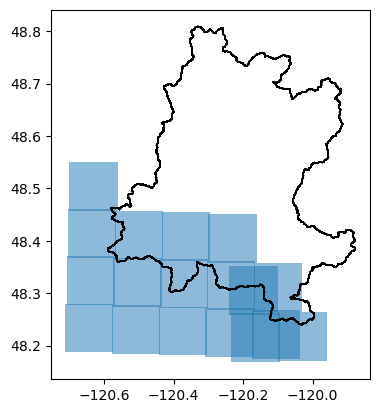

In [76]:
fig, ax = plt.subplots()
tnm_gdf.plot(ax=ax, alpha=0.5)
region2.plot(ax=ax, edgecolor='k', facecolor='none')

In [82]:
%%time

# Build ATL06 Request
parms = {
    "poly": region['poly'],
    "srt": icesat2.SRT_LAND,
    "t0": "2021-10-1T00:00:00Z",
    "t1": "2022-9-30T00:00:00Z",
    "cnf": 4,
    "ats": 20.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "maxi": 1,
    "atl08_class": [
        "atl08_ground"
    ],
    "H_min_win": 30,
    "sigma_r_max": 5.0,
    "samples": {"3dep": {"asset": "usgs3dep-1meter-dem", "catalog": geojson, "algorithm": "Cubic"}}
}

# Request ATL06 Data
gdf = icesat2.atl06p(parms)

# Display Statistics
print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
print("Cycles: {}".format(gdf["cycle"].unique()))
print("Received {} elevations".format(len(gdf)))

Reference Ground Tracks: [ 364  646 1248  204  806 1149 1309]
Cycles: [13 14 15 16]
Received 28990 elevations
CPU times: user 2.64 s, sys: 466 ms, total: 3.1 s
Wall time: 21.5 s


In [49]:
gdf.head()

,segment_id,n_fit_photons,cycle,distance,gt,h_sigma,rgt,w_surface_window_final,pflags,dh_fit_dy,h_mean,rms_misfit,dh_fit_dx,spot,geometry,3dep.flags,3dep.file_id,3dep.time,3dep.value
time,,,,,,,,,,,,,,,,,,,
2021-10-16 07:19:32.039333376,732782,16,13,1.467675e+07,30,0.126494,364,30.0,0,0.0,2089.849531,0.502636,0.323801,3,POINT (-120.43168 48.45837),NaN,NaN,NaN,NaN
2021-10-16 07:19:32.050669568,732786,19,13,1.467683e+07,30,0.214498,364,30.0,0,0.0,2118.875536,0.760384,0.338790,3,POINT (-120.43180 48.45765),NaN,NaN,NaN,NaN
2021-10-16 07:19:32.053509120,732787,24,13,1.467685e+07,30,0.345342,364,30.0,0,0.0,2123.835470,1.514607,0.228316,3,POINT (-120.43184 48.45748),NaN,NaN,NaN,NaN
2021-10-16 07:19:32.056344832,732788,18,13,1.467687e+07,30,0.058666,364,30.0,0,0.0,2126.093863,0.206501,0.128027,3,POINT (-120.43187 48.45730),NaN,NaN,NaN,NaN
2021-10-16 07:19:32.059178752,732789,20,13,1.467689e+07,30,0.064130,364,30.0,0,0.0,2128.564455,0.246445,0.117912,3,POINT (-120.43190 48.45712),NaN,NaN,NaN,NaN


In [48]:
gdf['3dep.value'].describe()

count                                      6811
unique                                     6811
top       [816.3962461640342, 816.067815988253]
freq                                          1
Name: 3dep.value, dtype: object

In [ ]:
gdf['h_mean'].describe()

In [51]:
len(gdf[~gdf['3dep.value'].isna()])

6811

In [52]:
len(gdf)

28990

In [83]:
gdf = gdf[gdf["3dep.value"].notna()]

In [84]:
def getFirstValue(x):
    if type(x["3dep.value"]) == float:
        return x['3dep.value']
    else:
        return x['3dep.value'][0]
gdf["3dep"] = gdf.apply(lambda x: getFirstValue(x), axis=1)

In [85]:
gdf = gdf[gdf["3dep"] > -9999.0]

<Axes: title={'center': '3DEP'}>

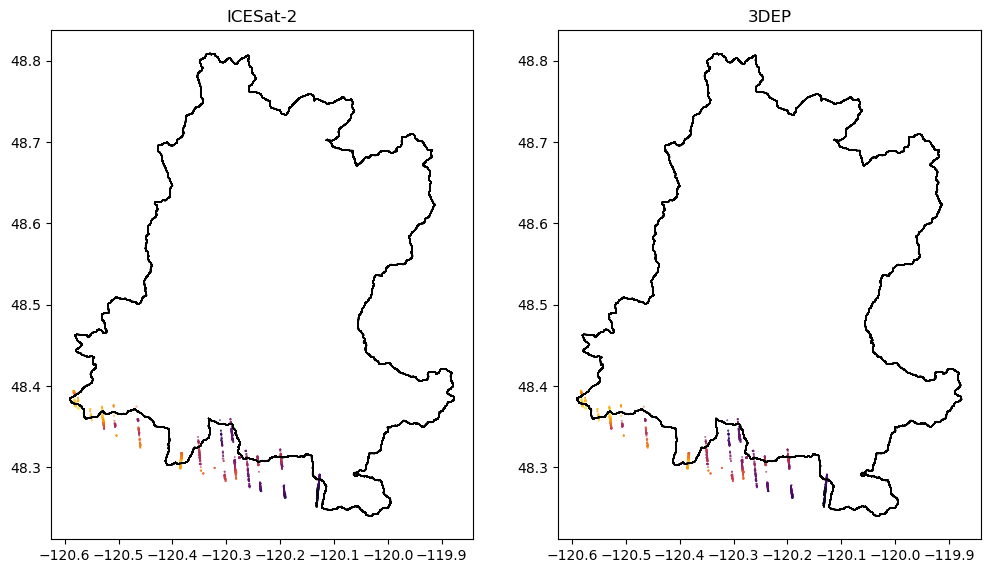

In [86]:
f, ax = plt.subplots(1, 2, figsize=[12,8])
ax[0].set_title("ICESat-2")
ax[0].set_aspect('equal')
gdf.plot(ax=ax[0], column='h_mean', cmap='inferno', s=0.1)
region2.plot(ax=ax[0], edgecolor='k', facecolor='none')
ax[1].set_title("3DEP")
ax[1].set_aspect('equal')
gdf.plot(ax=ax[1], column='3dep', cmap='inferno', s=0.1)
region2.plot(ax=ax[1], edgecolor='k', facecolor='none')

In [87]:
gdf = gpd.clip(gdf, region2)

<Axes: title={'center': '3DEP'}>

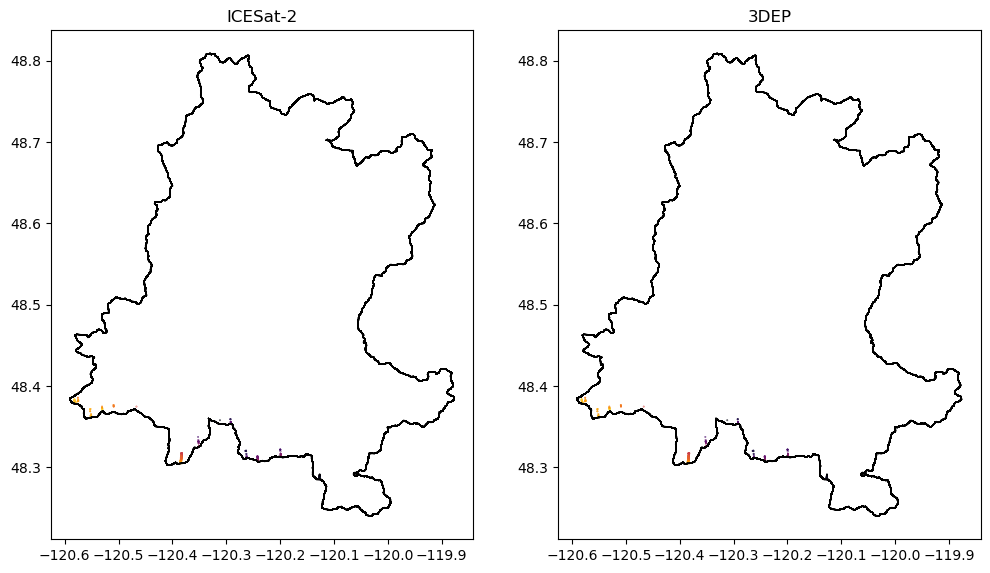

In [88]:
f, ax = plt.subplots(1, 2, figsize=[12,8])
ax[0].set_title("ICESat-2")
ax[0].set_aspect('equal')
gdf.plot(ax=ax[0], column='h_mean', cmap='inferno', s=0.1)
region2.plot(ax=ax[0], edgecolor='k', facecolor='none')
ax[1].set_title("3DEP")
ax[1].set_aspect('equal')
gdf.plot(ax=ax[1], column='3dep', cmap='inferno', s=0.1)
region2.plot(ax=ax[1], edgecolor='k', facecolor='none')

In [94]:
gdf.head()

,segment_id,n_fit_photons,cycle,distance,gt,h_sigma,rgt,w_surface_window_final,pflags,dh_fit_dy,h_mean,rms_misfit,dh_fit_dx,spot,geometry,3dep.flags,3dep.file_id,3dep.time,3dep
time,,,,,,,,,,,,,,,,,,,
2022-02-13 01:35:29.111714816,733731,85,14,1.469562e+07,50,0.037577,806,30.0,0,0.0,1039.012734,0.346414,-0.321034,5,POINT (-120.12734 48.28512),"[0, 0]","[55834574848, 55834574851]","[0.0, 0.0]",1038.932001
2022-02-13 01:35:29.108904960,733730,60,14,1.469560e+07,50,0.064468,806,30.0,0,0.0,1044.934139,0.451306,-0.275543,5,POINT (-120.12732 48.28530),"[0, 0]","[55834574848, 55834574851]","[0.0, 0.0]",1046.318899
2022-02-13 01:35:29.106092288,733729,33,14,1.469558e+07,50,0.095984,806,30.0,0,0.0,1049.535857,0.533694,-0.188929,5,POINT (-120.12729 48.28548),"[0, 0]","[55834574848, 55834574851]","[0.0, 0.0]",1052.020373
2022-02-13 01:35:29.103273984,733728,55,14,1.469556e+07,50,0.114072,806,30.0,0,0.0,1051.575294,0.810905,0.017249,5,POINT (-120.12727 48.28566),"[0, 0]","[55834574848, 55834574851]","[0.0, 0.0]",1053.199631
2022-02-13 01:35:29.100450048,733727,55,14,1.469554e+07,50,0.047328,806,30.0,0,0.0,1050.160250,0.316610,0.132228,5,POINT (-120.12724 48.28583),"[0, 0]","[55834574848, 55834574851]","[0.0, 0.0]",1051.549790


In [89]:
len(gdf)

340

In [95]:
gdf = gdf.drop(columns=['3dep.value','3dep.flags', '3dep.file_id', '3dep.time'])

In [97]:
out_fn = '../../data/methow_test_3dep.geojson'

gdf.to_file(out_fn, driver="GeoJSON") 

In [65]:
bbox

[{'lat': 48.23998489506269, 'lon': -120.59027418539792},
 {'lat': 48.23998489506269, 'lon': -119.87668762088924},
 {'lat': 48.80903197587903, 'lon': -119.87668762088924},
 {'lat': 48.80903197587903, 'lon': -120.59027418539792},
 {'lat': 48.23998489506269, 'lon': -120.59027418539792}]

# Code for comparing Methow sampling to SlideRule 3dep sampling.  
Incomplete notebook - just keeping the code in case I want to reproduce these efforts later.

## Compare to 3dep

In [15]:
coord = [(pt.x, pt.y) for pt in dep_gdf.to_crs(lidar_snowoff_src.crs).geometry]

bicubic_interp_3dep = core.interpolate(lidar_fn, coord, offset=3, kind='cubic')

In [16]:
dep_gdf['bicubic_lidar_z'] = bicubic_interp_3dep

In [60]:
dep_gdf['difference_bicubic'].describe()

count    338.000000
mean      -0.500028
std        2.569377
min      -21.067148
25%       -1.838787
50%       -0.393713
75%        0.640161
max       12.926314
Name: difference_bicubic, dtype: float64

In [61]:
dep_gdf['difference_3dep'].describe()

count    340.000000
mean      -0.479200
std        2.608950
min      -31.078445
25%       -1.705565
50%       -0.346021
75%        0.682472
max       10.062937
Name: difference_3dep, dtype: float64

In [35]:
dep_gdf['difference_bicubic'] = dep_gdf['h_mean'] - dep_gdf['bicubic_lidar_z']

In [40]:
dep_gdf = dep_gdf.assign(diff_plus_bicubic = dep_gdf['difference_bicubic'] - (-0.436195635256297))

In [41]:
dep_gdf['difference_3dep'] = dep_gdf['h_mean'] - dep_gdf['3dep']

In [67]:
dep_gdf['compare_3dep'] = dep_gdf['difference_bicubic'] - dep_gdf['difference_3dep']

In [68]:
dep_gdf['compare_3dep'].describe()

count    338.000000
mean      -0.025796
std        1.180365
min       -4.522874
25%       -0.558769
50%       -0.038093
75%        0.415120
max       10.011297
Name: compare_3dep, dtype: float64

In [28]:
dep_gdf['diff_plus_bicubic'].describe()

count     338.000000
mean     1619.681926
std       362.895766
min       918.643372
25%      1314.723985
50%      1663.623359
75%      1947.720467
max      2234.270775
Name: diff_plus_bicubic, dtype: float64

In [30]:
dep_gdf['dif_bicubic_3dep'].describe()

count    338.000000
mean       0.461992
std        1.180365
min       -9.575101
25%        0.021075
50%        0.474289
75%        0.994965
max        4.959070
Name: dif_bicubic_3dep, dtype: float64

<AxesSubplot: >

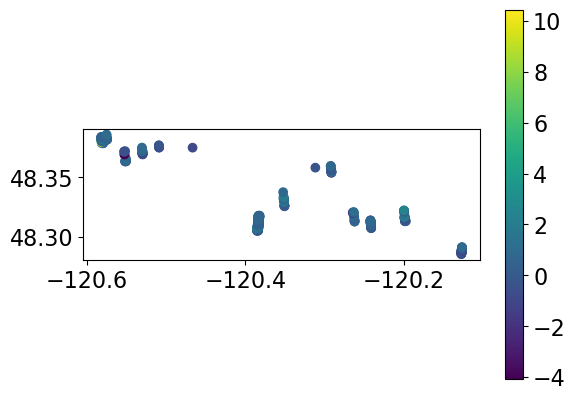

In [43]:
dep_gdf.plot(column='compare_3dep', legend=True)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  6.,  5., 10., 20., 23.,
        31., 51., 56., 48., 29., 13., 23.,  8.,  4.,  3.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([-4.08667885, -3.79599542, -3.50531199, -3.21462856, -2.92394513,
        -2.63326169, -2.34257826, -2.05189483, -1.7612114 , -1.47052797,
        -1.17984454, -0.88916111, -0.59847768, -0.30779425, -0.01711082,
         0.27357262,  0.56425605,  0.85493948,  1.14562291,  1.43630634,
         1.72698977,  2.0176732 ,  2.30835663,  2.59904006,  2.8897235 ,
         3.18040693,  3.47109036,  3.76177379,  4.05245722,  4.34314065,
         4.63382408,  4.92450751,  5.21519094,  5.50587437,  5.79655781,
         6.08724124,  6.37792467,  6.6686081 ,  6.95929153,  7.24997496,
         7.54065839,  7.83134182,  8.12202525,  8.41270869,  8.70339212,
         8.99407555,  9.28475898,  9.57544241,  9.86612584,

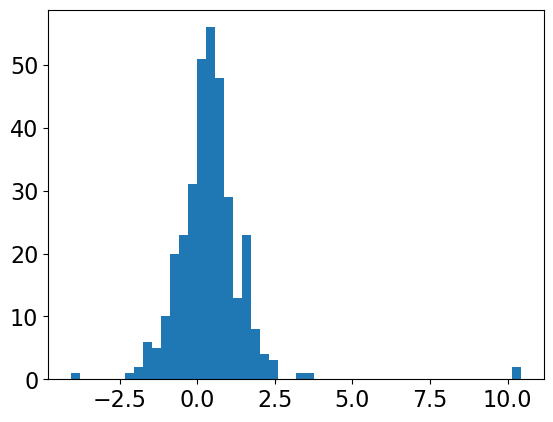

In [44]:
plt.hist(dep_gdf['compare_3dep'], bins=50)

In [45]:
dep_gdf['compare_3dep'].describe()

count    338.000000
mean       0.410400
std        1.180365
min       -4.086679
25%       -0.122573
50%        0.398102
75%        0.851316
max       10.447493
Name: compare_3dep, dtype: float64

Text(0.5, 1.0, 'Difference between: ATL06SR - 3dep \nand ATL06SR - DNR')

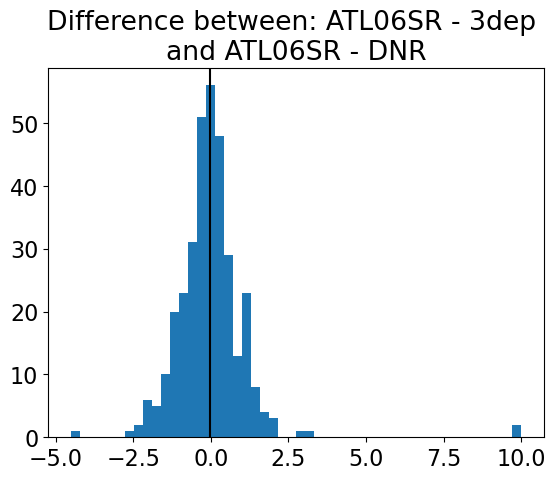

In [64]:
fig, ax = plt.subplots()
plt.hist((dep_gdf['difference_bicubic'] - dep_gdf['difference_3dep']), bins=50)
plt.axvline(x=np.nanmedian(dep_gdf['difference_bicubic'] - dep_gdf['difference_3dep']), color='k')
plt.title('Difference between: ATL06SR - 3dep \nand ATL06SR - DNR')